Project Ideas


suggested project: analyse wind speed around the country with a view to a wind farm


## Project Plan

__Research wind farms in Ireland__

- where are they usually located?
- what wind conditions do they need? any other site considerations? Rural locations.
- how much electricity do they generate? summer vs winter?
- cost?
- lifespan?
- advantages
- disadvantages
- anything else?

__Project questions__

What's the relationship between wind speed and power generated? Does the wind direction affect power generation? 

Is there a trend in wind speed? Is Ireland getting winder? Variations across the year? Time of day?

Is the technology in wind turbines improving? Is more electricity being generated for the same wind speed?

Does rain/temperature/anything affect the output? 

What happens during a storm? Does amount of wind generated electricity decrease/increase? 

Predict power output for wind farms in Ireland for the next week. Tricky

As I have weather information could solar power to fill the gaps when wind speeds are low? Probably too big a task for this project. 


__Find data__

Weather data from met Éireann historical data.
    can select by site, perhaps initially analyse data for a number of weather stations near a wind farm and also weather stations not near a wind farm. From the data can I see why that site was selected?



Is there much variation in wind across the country? Eirgrid data for entire country. 

## Introduction

Background information

https://windenergyireland.com/about-wind/the-basics/facts-stats

## The Data

About the data set. 

## Organising and Cleaning the Data


Would be convenient to have all the data in one large data set. Need to research working with large data sets. More difficult to load than smaller data sets.

Clean data

In [10]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

## Wind electricity data

https://www.smartgriddashboard.com/#all

[Eirgrid real-time system information](https://www.eirgrid.ie/grid/real-time-system-information) . On the Eirgrid website it is only possible to view information for one day at a time and up to one month ago. Despite extensive searching I couldn't find an official source of Eirgrid histprical data. I did find a [GitHub repository by Daniel Parke](https://github.com/Daniel-Parke/EirGrid_Data_Download/tree/main), who has written a very helpful python file to download all the historical data. His GitHub repository contains raw csv files for actual amount of electricity generated, actual demand, actual amount of electricity produced by wind for every year from 2014 for all Ireland, Northern Ireland and Republic of Ireland. I will need to run his program to get the most up to date data for 2024.

As my weather data will be only for the Republic of Ireland, I am only interested in the csv files for the actual amount of electricity produced by wind for the Republic of Ireland. Each csv file containing one years worth of information was downloaded from the GitHub repository. After reading the data into pandas the next task will be to merge the files vertically using pd.concat(). Before I started on the onerous task of loading and concatenating each file separately, I came across a blog post on how to [read multiple csv file into pandas](https://saturncloud.io/blog/how-to-read-multiple-csv-files-into-python-pandas-dataframe). 

The solution to reading multiple files into pandas uses the glob module. Glob is a built-in module used to retrieve files/pathnames matching a specified pattern. It uses * wild cards to make path retrieval more simple and convenient. https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/. [Real python](https://realpython.com/get-all-files-in-directory-python/#conditional-listing-using-glob) states that glob.glob() returns a list of filenames that match a pattern, which in this case are csv files. 

```python
# Search for all csv files in the current working directory
import glob
glob.glob('*.csv')
```

Eirgrid have data on actual wind generation and the forecast wind generation. Could getting forecast information be of interest? Might help with machine learning. Github repository only contains actual data not forecast data. 

set up a scheduled task to download the data at midnight?


In [11]:
# Load the wind electricity files

# Find all csv files in the data/electricity directory
csv_files = glob.glob('data/electricity/*.csv')

# Create an empty dataframe to store the combined data
electricity_df = pd.DataFrame()

# Loop through each CSV file and append its contents to the combined dataframe
for csv_file in csv_files:
    df = pd.read_csv(csv_file, 
                     header = None, 
                     names = ['date', 'wind_actual', 'location', 'wind_value'], 
                     index_col= 'date',
                     parse_dates= ['date'],
                     usecols= ['date', 'wind_value'])
    electricity_df = pd.concat([electricity_df, df])

electricity_df.head()

,wind_value
date,
2021-01-01 00:00:00,2087.0
2021-01-01 00:15:00,2095.0
2021-01-01 00:30:00,2079.0
2021-01-01 00:45:00,2088.0
2021-01-01 01:00:00,2077.0


In [12]:
electricity_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 361152 entries, 2021-01-01 00:00:00 to 2020-01-01 21:45:00
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   wind_value  361004 non-null  float64
dtypes: float64(1)
memory usage: 5.5 MB


In [13]:
electricity_df.isna().sum()

wind_value    148
dtype: int64

have a lot of duplicated rows. csv files have data for the 1st jan for the following year. 

In [14]:
electricity_df.index.duplicated().sum()

np.int64(10472)

In [ ]:
# https://stackoverflow.com/questions/13035764/remove-pandas-rows-with-duplicate-indices

electricity_df = electricity_df[~electricity_df.index.duplicated(keep= 'first')]
electricity_df.head()

,wind_value
date,
2021-01-01 00:00:00,2087.0
2021-01-01 00:15:00,2095.0
2021-01-01 00:30:00,2079.0
2021-01-01 00:45:00,2088.0
2021-01-01 01:00:00,2077.0


In [16]:
electricity_df = electricity_df.sort_index()

In [17]:
electricity_df.shape

(350680, 1)

In [18]:
electricity_df.to_csv('data/electricity/electricity_data.csv')

In [20]:
hourly_electricity_df = electricity_df.resample('h').mean()
hourly_electricity_df.head()

,wind_value
date,
2014-01-01 00:00:00,976.75
2014-01-01 01:00:00,914.25
2014-01-01 02:00:00,938.50
2014-01-01 03:00:00,911.25
2014-01-01 04:00:00,915.00


In [21]:
hourly_electricity_df.to_csv('data/electricity/hourly_electricity.csv')

## Weather Data

The weather data was downloaded from historic met eireann sites. Data from a range of weather stations was downloaded. The selected weather stations were mostly based on their proximity to a wind farm. A number were selected for the size of the data set. To see if Ireland is getting windier. Oldest weather stations with data are Dublin airport and Valentia who have data from 1 Jan 1944. 

Met Eireann weather data is recorded hourly. Electricity data recorded every 15min - resample to 1 hour. Can this resampled data be saved to a new csv file? Would make analysis easier. 

Today's task
Is Ireland getting windier>

## Exploratory Data Analysis

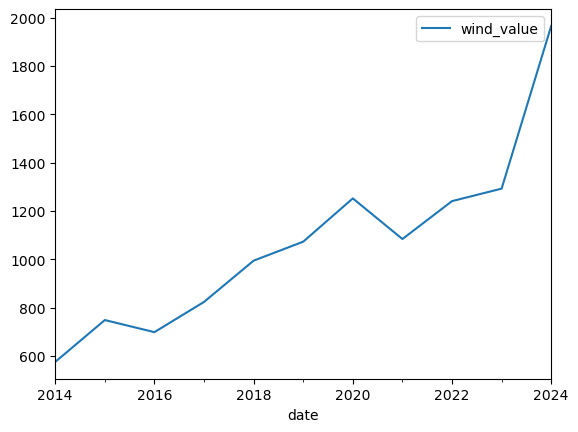

In [6]:
# Very quick plot of electricity generation by year

mean_wind_elect_year = electricity_df.resample('YE').mean()

mean_wind_elect_year.plot()
plt.show()

## Discussion of the Analysis

nice plots

## Machine Learning

some predictive analysis.

## Conclusion



## References

### Data Sets

[GitHub Daniel Parke]https://github.com/Daniel-Parke/EirGrid_Data_Download/tree/main


__Problems that arose__

[Git LFS (large file storage)](https://git-lfs.com/). Some of the weather data filew were larger than GitHub's recommended maximum file size of 50.00 MB. Installed and used Git lfs
